In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('yellow_tripdata_2016-01.csv.zip')

In [3]:
original = df.copy()

In [4]:
df.shape

(10906858, 19)

**sampling the df since it's too big:**

In [5]:
df.sort_values(by='tpep_pickup_datetime')
df = df.iloc[:1000000, :]

In [6]:
# df = df.sample(1000000, random_state=42)

In [7]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RatecodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')

In [8]:
relevant_feats = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'pickup_longitude',
                  'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'fare_amount']

coordinates_feats = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

In [9]:
df.sample(5)[relevant_feats].T

,597114,546490,909998,850047,49464
tpep_pickup_datetime,2016-01-02 21:21:16,2016-01-02 16:41:27,2016-01-03 20:15:36,2016-01-03 16:42:46,2016-01-01 00:26:20
tpep_dropoff_datetime,2016-01-02 21:34:45,2016-01-02 16:49:22,2016-01-03 20:21:23,2016-01-03 17:12:16,2016-01-01 00:42:29
passenger_count,1,2,1,1,1
trip_distance,2.24,1.93,0.9,7.8,3.1
pickup_longitude,-73.973274,-73.932213,-74.002571,-73.863197,-73.9767
pickup_latitude,40.747776,40.79549,40.733822,40.768723,40.793118
dropoff_longitude,-73.987686,-73.955338,-73.990913,-73.941505,-73.958778
dropoff_latitude,40.72142,40.785801,40.734455,40.707279,40.778316
fare_amount,10.5,8.0,6.0,25.5,13.5


leakage - 'tpep_dropoff_datetime',
enrich - 'trip_distance' (external API, euclidean / manhattan)
valid - 'tpep_pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

**converting datetime features to be of type datetime and creating the target for the duration predictions model:**

In [10]:
df['pickup_datetime'] = df['tpep_pickup_datetime'].astype('datetime64')
df['dropoff_datetime'] = df['tpep_dropoff_datetime'].astype('datetime64')

In [11]:
df['pickup_day'] = df['pickup_datetime'].dt.day_of_week
df['dropoff_day'] = df['dropoff_datetime'].dt.day_of_week

In [12]:
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['dropoff_hour'] = df['dropoff_datetime'].dt.hour

In [13]:
df['pickup_minute'] = df['pickup_datetime'].dt.minute
df['dropoff_minute'] = df['dropoff_datetime'].dt.minute

In [14]:
df['duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).apply(lambda td: td.seconds/60)
df['duration'].sample(5)

400016     3.200000
492544     7.550000
693229    18.450000
638548    15.083333
959695    23.783333
Name: duration, dtype: float64

In [15]:
duration_target = 'duration'

In [16]:
engineered_feats = ['dropoff_datetime', 'pickup_datetime', 'pickup_day', 'dropoff_day', 
                    'pickup_hour', 'dropoff_hour', 'pickup_minute', 'dropoff_minute', 'duration']
relevant_feats.extend(engineered_feats)

relevant_feats.remove('tpep_dropoff_datetime')
relevant_feats.remove('tpep_pickup_datetime')
relevant_feats

['passenger_count',
 'trip_distance',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'fare_amount',
 'dropoff_datetime',
 'pickup_datetime',
 'pickup_day',
 'dropoff_day',
 'pickup_hour',
 'dropoff_hour',
 'pickup_minute',
 'dropoff_minute',
 'duration']

**integrity checks:**

In [17]:
len(df[df['pickup_datetime'] < df['dropoff_datetime']])

998884

In [18]:
len(df[df['pickup_datetime'] >= df['dropoff_datetime']])

1116

In [19]:
len(df[df['fare_amount'] > 0])

999267

In [20]:
len(df[df['fare_amount'] <= 0])

733

In [21]:
len(df[df['trip_distance'] <= 0])

6562

In [22]:
len(df['passenger_count'] > 0)

1000000

In [23]:
df['passenger_count'].value_counts()

1    662767
2    170420
5     53982
3     51040
6     32432
4     29293
0        58
8         5
7         3
Name: passenger_count, dtype: int64

In [24]:
for feat in coordinates_feats:
    print(f'{feat}: {(df[feat] == 0).sum()}')

pickup_longitude: 16302
pickup_latitude: 16302
dropoff_longitude: 15590
dropoff_latitude: 15590


**dropping off invalid data:**

In [25]:
df.shape

(1000000, 28)

In [26]:
df = df[df['pickup_datetime'] < df['dropoff_datetime']]

In [27]:
df.shape

(998884, 28)

In [28]:
df = df[df['fare_amount'] > 0]

In [29]:
df.shape

(998186, 28)

In [30]:
df = df[df['trip_distance'] > 0]

In [31]:
df.shape

(992841, 28)

In [32]:
df = df[np.logical_or(df['passenger_count'] == 2, df['passenger_count'] == 1)]

In [33]:
df['passenger_count'].value_counts()

1    657449
2    169345
Name: passenger_count, dtype: int64

In [34]:
df.shape

(826794, 28)

In [35]:
indices0 = df[coordinates_feats].isin([0]).any(axis=1)
df = df[~indices0]

In [36]:
df.shape

(813262, 28)

**some visualizations:**

<ipython-input-37-0973ddab7f8f>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


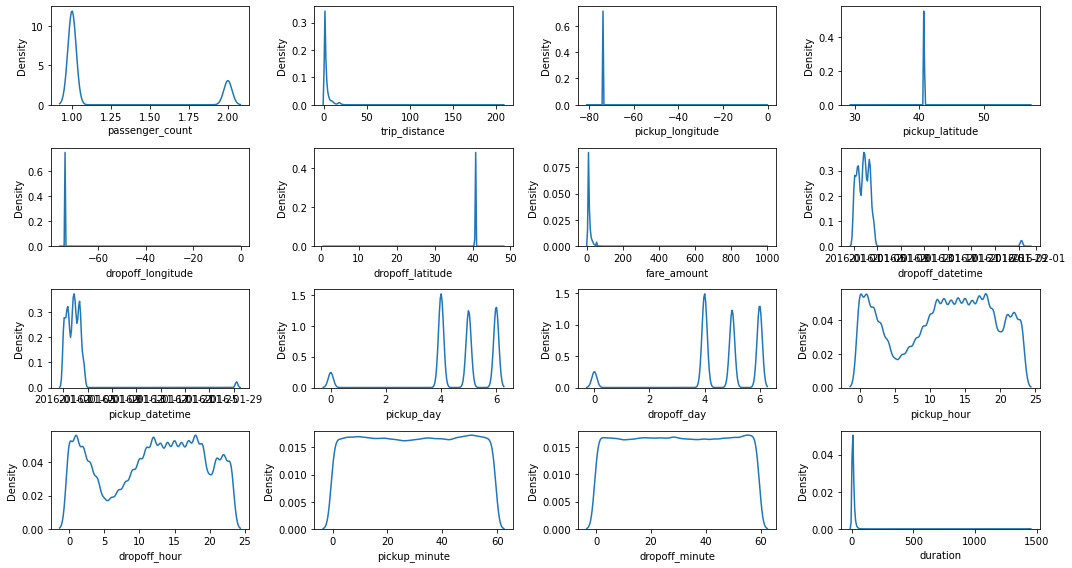

In [37]:
fig = plt.figure(figsize=(15, 8))

for i, feat in enumerate(relevant_feats):        
    plt.subplot(4, 4, i + 1)
    sns.kdeplot(df[feat])
    
fig.tight_layout()
fig.show()

**taking care of outliers in these features:**

- trip_distance
- fare_amount
- duration
- coordinates features

In [38]:
copy = df.copy()

In [39]:
outliers_feats = ['trip_distance', 'fare_amount', 'duration']
outliers_feats.extend(coordinates_feats)
for feat in outliers_feats:
    Q1 = copy[feat].quantile(.25)
    Q3 = copy[feat].quantile(.75)
    IQR = Q3 - Q1
    
    bottom_bound = Q1 - 1.5 * IQR
    top_bound = Q3 + 1.5 * IQR
    
    print(f'{feat}\nbottom: {bottom_bound}\ttop: {top_bound}\nIQR: {IQR}\n')
    
    print(f'shape before: {df.shape}')
    df = df[df[feat].between(bottom_bound, top_bound)]
    print(f'shape after: {df.shape}\n')

trip_distance
bottom: -2.5549999999999997	top: 7.164999999999999
IQR: 2.4299999999999997

shape before: (813262, 28)
shape after: (725770, 28)

fare_amount
bottom: -4.75	top: 25.25
IQR: 7.5

shape before: (725770, 28)
shape after: (722658, 28)

duration
bottom: -8.741666666666664	top: 29.85833333333333
IQR: 9.649999999999999

shape before: (722658, 28)
shape after: (717982, 28)

pickup_longitude
bottom: -74.03041458129883	top: -73.92656326293945
IQR: 0.02596282958984375

shape before: (717982, 28)
shape after: (702044, 28)

pickup_latitude
bottom: 40.683513641357436	top: 40.81989669799803
IQR: 0.034095764160149145

shape before: (702044, 28)
shape after: (693546, 28)

dropoff_longitude
bottom: -74.03657531738278	top: -73.91505432128909
IQR: 0.03038024902342329

shape before: (693546, 28)
shape after: (687377, 28)

dropoff_latitude
bottom: 40.67919731140137	top: 40.824323654174805
IQR: 0.036281585693359375

shape before: (687377, 28)
shape after: (678344, 28)



C:\Users\haimk\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\haimk\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\haimk\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\haimk\anaconda3\lib\si

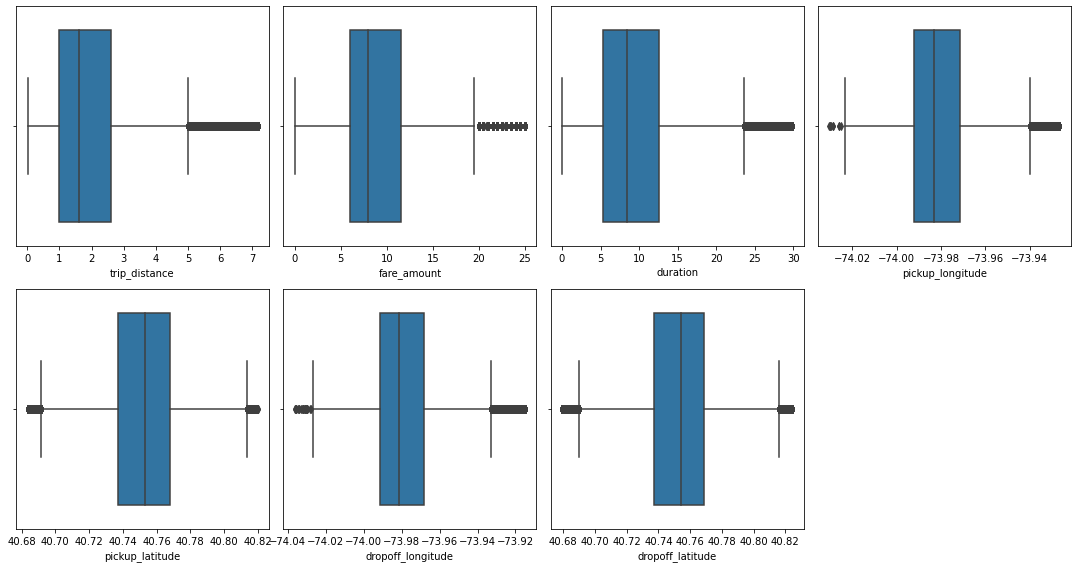

In [40]:
fig = plt.figure(figsize=(15, 8))

for i, feat in enumerate(outliers_feats):
    plt.subplot(2, 4, i + 1)
    sns.boxplot(df[feat])
    plt.xlabel(feat)

fig.tight_layout()
fig.show()

In [41]:
df[relevant_feats].describe().T

,count,mean,std,min,25%,50%,75%,max
passenger_count,678344.0,1.201774,0.401324,1.000000,1.000000,1.000000,1.000000,2.000000
trip_distance,678344.0,1.972081,1.358385,0.010000,1.000000,1.600000,2.600000,7.160000
pickup_longitude,678344.0,-73.981314,0.016437,-74.030319,-73.992188,-73.983009,-73.971252,-73.926567
pickup_latitude,678344.0,40.752762,0.022198,40.683529,40.737263,40.752926,40.767761,40.819893
dropoff_longitude,678344.0,-73.979382,0.018364,-74.036293,-73.991615,-73.981644,-73.968102,-73.915062
dropoff_latitude,678344.0,40.753096,0.024374,40.679199,40.737309,40.753979,40.768803,40.824322
fare_amount,678344.0,9.150012,4.238773,0.010000,6.000000,8.000000,11.500000,25.000000
pickup_day,678344.0,4.670456,1.403181,0.000000,4.000000,5.000000,6.000000,6.000000
dropoff_day,678344.0,4.671249,1.410533,0.000000,4.000000,5.000000,6.000000,6.000000
pickup_hour,678344.0,12.182282,6.903944,0.000000,7.000000,13.000000,18.000000,23.000000


In [42]:
df[relevant_feats].describe(exclude=np.number).T

<ipython-input-42-3b21a08b2d65>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df[relevant_feats].describe(exclude=np.number).T
<ipython-input-42-3b21a08b2d65>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df[relevant_feats].describe(exclude=np.number).T


,count,unique,top,freq,first,last
dropoff_datetime,678344,238801,2016-01-01 01:22:51,16,2016-01-01 00:01:17,2016-01-29 12:39:56
pickup_datetime,678344,235954,2016-01-01 00:21:45,16,2016-01-01 00:00:01,2016-01-29 12:11:06


In [43]:
from sklearn.preprocessing import StandardScaler

In [44]:
output_feats = ['pickup_day', 'pickup_hour', 'pickup_minute', 'passenger_count', 'trip_distance', 
               'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
               'fare_amount', 'duration']

In [45]:
to_scale = df[output_feats]
scaler = StandardScaler()
scaler.fit(to_scale)
scaled_data = scaler.transform(to_scale)
scaled_df = pd.DataFrame(scaled_data, columns=output_feats)

In [46]:
price_feats = ['pickup_day', 'pickup_hour', 'pickup_minute', 'passenger_count', 'trip_distance', 
               'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
               'fare_amount']

duration_feats = ['pickup_day', 'pickup_hour', 'pickup_minute', 'trip_distance', 
                  'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
                  'duration']

In [47]:
final_write = scaled_df[price_feats]
final_write.head()

,pickup_day,pickup_hour,pickup_minute,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount
0,-0.477812,-1.764541,-1.704535,-0.502770,-0.568382,0.115029,-0.367057,-0.689024,0.034806,-0.035390
1,-0.477812,-1.764541,-1.704535,-0.502770,0.911317,-1.036111,-1.300375,-0.896753,-2.654296,0.554403
2,-0.477812,-1.764541,-1.704535,-0.502770,-0.870212,-1.510956,-0.353309,-0.784995,-0.478224,-0.743143
3,-0.477812,-1.764541,-1.704535,-0.502770,1.272040,-1.398627,-0.473948,-1.523679,-1.893829,1.144197
4,-0.477812,-1.764541,-1.704535,1.988981,0.167787,-0.649922,-1.539934,-1.402365,-0.539575,0.436445


In [48]:
compression_opts = dict(method='zip', archive_name='price_model_data.csv')
final_write.to_csv('price_model_data.zip', compression=compression_opts)

In [49]:
final_read = pd.read_csv('price_model_data.zip')
final_read.drop(columns=['Unnamed: 0'], inplace=True)
final_read.head()

,pickup_day,pickup_hour,pickup_minute,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount
0,-0.477812,-1.764541,-1.704535,-0.502770,-0.568382,0.115029,-0.367057,-0.689024,0.034806,-0.035390
1,-0.477812,-1.764541,-1.704535,-0.502770,0.911317,-1.036111,-1.300375,-0.896753,-2.654296,0.554403
2,-0.477812,-1.764541,-1.704535,-0.502770,-0.870212,-1.510956,-0.353309,-0.784995,-0.478224,-0.743143
3,-0.477812,-1.764541,-1.704535,-0.502770,1.272040,-1.398627,-0.473948,-1.523679,-1.893829,1.144197
4,-0.477812,-1.764541,-1.704535,1.988981,0.167787,-0.649922,-1.539934,-1.402365,-0.539575,0.436445
